In [7]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
from mmfutils.contexts import NoInterrupt
from mmfutils.plot import imcontourf
from importlib import reload  # Python 3.4+
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import quad
from uncertainties import ufloat
import homogeneous;reload(homogeneous)
import bcs;reload(bcs)
from bcs import BCS
import vortex_1d_aslda;reload(vortex_1d_aslda)
import vortex_2d_aslda;reload(vortex_2d_aslda)
import itertools  
from IPython.display import display, clear_output
%pylab inline --no-import-all

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib


In [8]:
hbar = 1
m = 1
mu_eff = 1.0
n = 1.0
e_F = 1.0
k_F = np.sqrt(2*m*e_F)
n_F = k_F**3/3/np.pi**2
E_FG = 2./3*n_F*e_F
mu = 0.59060550703283853378393810185221521748413488992993*e_F #I change this number
delta = 0.68640205206984016444108204356564421137062514068346*e_F
grid_size = 32
lda = vortex_2d_aslda.ASLDA(Nxy=(grid_size,)*2)
k_c = abs(lda.kxy[0]).max()
E_c = (lda.hbar*k_c)**2/2/lda.m
lda = vortex_2d_aslda.ASLDA(Nxy=(grid_size,)*2, Lxy=(0.4,)*2, E_c=E_c)

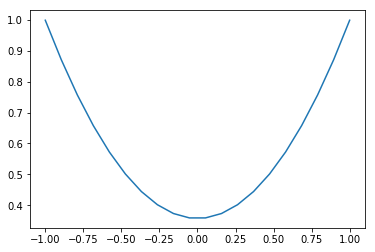

In [9]:
ps = np.linspace(-1,1,20)
plt.plot(ps,lda._G(ps))

In [10]:
class ASLDA_(vortex_1d_aslda.ASLDA):
    def get_alphas(self, ns = None):
        return super().get_alphas(ns)
        #alpha_a,alpha_b,alpha_p =np.ones(self.Nx),np.ones(self.Nx),np.ones(self.Nx)
        #return (alpha_a,alpha_b,alpha_p)       

def iterate(lda, mudelta, na_avg=0.5, nb_avg=0.5, N_twist=0, **kw):
    mu_a, mu_b, na,nb, mu_a_eff, mu_b_eff, delta,taus,kappa = mudelta
    mus = (mu_a_eff, mu_b_eff)
    if na is None:
        na = np.ones(lda.Nx) * na_avg
    if nb is None:
        nb = np.ones(lda.Nx) * nb_avg
    #H = lda.get_H(mus=mus,delta = delta,ns=(na,nb),taus = taus,kappa=kappa)
    ns_,taus_,kappa_ = lda.get_ns_taus_kappa_average_3d(mus=mus,delta = delta,ns=(na,nb),taus = taus,kappa=kappa) #lda.get_ns_taus_kappa(H) 
    clear_output()
    plt.plot(lda.x,ns_[0].real)
    plt.plot(lda.x,ns_[1].real)
    display(plt.gcf())
    
    gx = lda.gx(ns_,taus_,kappa_)
    na_,nb_ = ns_ # the new densities are not used in the iteration, just used for compute new mus
    nomral_na = na_.mean() / (na_.mean() + nb_.mean())
    nomral_nb = nb_.mean() / (na_.mean() + nb_.mean())
    mu_a = mu_a*(1 + (na_avg - nomral_na))
    mu_b = mu_b*(1 + (nb_avg - nomral_nb))
    lr = 0.4
    lo = 1 - lr
    v_a,v_b = lda.get_modified_Vs(delta=delta,ns=(na_,nb_),taus=taus_,kappa=kappa_,alphas=lda.get_alphas((na_,nb_)))
    mu_a_eff = mu_a + v_a * nb
    mu_b_eff = mu_b + v_b * na
    #delta = lda.g_eff*kappa 
    print(mu_a_eff.real.max(),mu_b_eff.real.max(),delta.real.max(), na_.real.mean(), nb_.real.mean(),gx.real.mean())
    return (mu_a, mu_b,lo*na + lr*na_,lo*nb + lr*nb_, mu_a_eff, mu_b_eff, delta,taus_,kappa_)


In [11]:
def test_iterate_ASLDA():
    grid_size = 64
    aslda = ASLDA_(Nx=grid_size)
    k_c = abs(aslda.kx).max()
    E_c = (aslda.hbar*k_c)**2/2/aslda.m # 3 dimension, so E_c should have a factor of 3
    aslda = ASLDA_(Nx=grid_size, Lx=0.4, E_c=E_c)
    mu_eff = 1.0
    n = 1.0
    k_F = np.sqrt(2*m*E_c)
    n_F = k_F**3/3/np.pi**2
    E_FG = 2./3*n_F*E_c
    mu = 1# 0.59060550703283853378393810185221521748413488992993*E_c
    delta = 1# 0.68640205206984016444108204356564421137062514068346*E_c
    qT = (mu, mu) +(None,None)+ (mu_eff*np.ones(aslda.Nx),)*2 + (delta * np.ones((aslda.Nx),), None,None)
    max_iteration = 5
    v_0, n, mu, e_0 = homogeneous.get_BCS_v_n_e(delta=delta, mu_eff=mu_eff)
    x = 0.5
    N = 10
    while max_iteration > 0:
        if N < 0:
            break
        N = N - 1
        qT = iterate(lda=aslda,mudelta = qT, N_twist=np.inf,na_avg=1/(1+x), nb_avg=x/(1+x), abs_tol=1e-2)

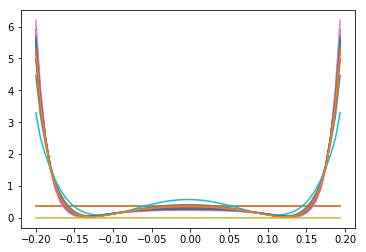

110.50382652548231 3.907232910564472 1.0 0.6250597999855894 0.6250624226497845 41.655633157559215


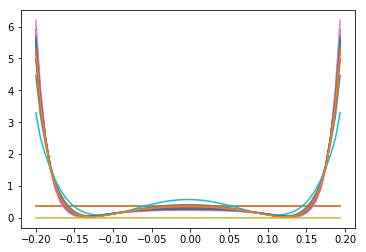

In [12]:
test_iterate_ASLDA()